# Intrinsic calibration using Deep Learning and Alternating Optimization

## Objective
The goal of this project is to estimate intrinsic matrix from a camera using a neural network.

## Applications
- 3D reconstruction
- Depth perception

In [5]:
import torch
import dataloader 
import model
import numpy as np
import train
import losses
%matplotlib widget
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
loader = dataloader.SyntheticLoader()

## Dataset
This dataset is synthetically generated on-the-fly using the FLAME 3D face model.
Each sample is a 100-frame sequence of a randomly generated face identity, represented by FLAME shape coefficients sampled uniformly in [-2, 2], and expressed through 68 3D facial landmarks.

The face undergoes smooth head motion with rotations up to ±20° per axis and translations with depth in [1.5, 3.5].
Landmarks are projected using a perspective camera model with focal length sampled in [0.6W, 1.2W]
Zero-mean Gaussian noise with σ = 0.5 px is added to the 2D landmarks.

The dataset provides full ground truth for FLAME shape parameters, 3D landmarks, 2D projections, camera intrinsics, and camera motion, and is generated entirely at runtime.

In [2]:
sample = loader[0]
x = sample['x_img'].float().to(device)
x_gt = sample['x_img_gt'].float().to(device)
k_gt = sample['K_gt'].float().to(device)
R_gt = sample['R_gt'].float().to(device)
T_gt = sample['T_gt'].float().to(device)
S_gt = sample['x_w_gt'].float().to(device)
print(f"Sample K:\n{k_gt}") 
print(f"Sample R:\n{R_gt[0]}") 
print(f"Sample T:\n{T_gt[0]}")

Sample K:
tensor([[1.8587e+03, 0.0000e+00, 7.9297e+02],
        [0.0000e+00, 1.8618e+03, 4.6150e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])
Sample R:
tensor([[ 0.9212,  0.2838, -0.2661],
        [-0.2723,  0.9589,  0.0800],
        [ 0.2779, -0.0013,  0.9606]])
Sample T:
tensor([-0.1654, -0.1142,  1.6275])


Face and image sample 

C:\Users\minhh\AppData\Local\Temp\ipykernel_20204\2382819088.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\minhh\AppData\Local\Temp\ipykernel_20204\2382819088.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


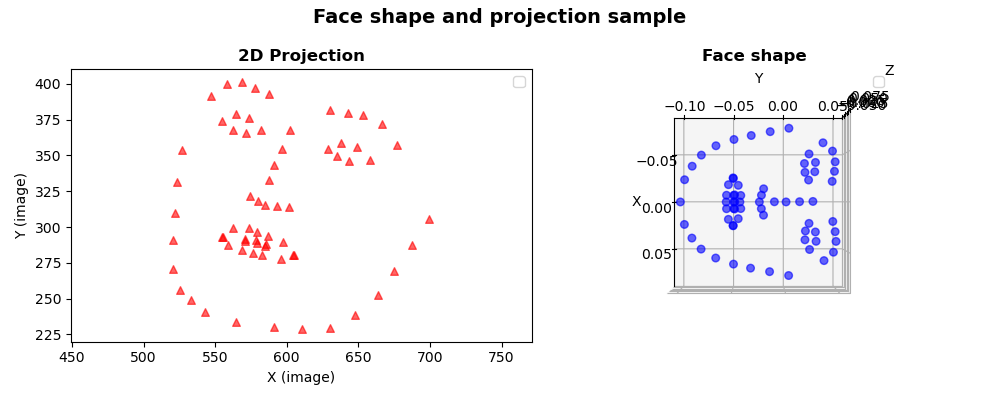

In [3]:
fig = plt.figure(figsize=(10, 4))

# Left subplot: Predicted (x)
ax1 = fig.add_subplot(121) 
ax1.scatter(x[0,0].cpu(), x[0,1].cpu(), c='red', marker='^', s=30, alpha=0.6) 
ax1.set_xlabel('X (image)') 
ax1.set_ylabel('Y (image)') 
ax1.set_title('2D Projection', fontsize=12, fontweight='bold') 
ax1.legend() 
ax1.axis('equal')

# Right subplot: Ground Truth (S_gt)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(S_gt[:,0].cpu(), S_gt[:,1].cpu(), S_gt[:,2].cpu(),
            c='blue', marker='o', s=30, alpha=0.6)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Face shape', fontsize=12, fontweight='bold')
ax2.legend()
ax2.view_init(elev=90, azim=0)

plt.suptitle('Face shape and projection sample', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Model Architecture
### Idea
The model consists of two PointNet-based networks that operate on 2D facial landmark sequences.

- **Shape Network** predicts FLAME shape coefficients from the 2D landmark trajectories. The predicted shape parameters are averaged across frames and decoded into 3D facial landmarks using the FLAME shape space.

- **Calibration Network** predicts camera intrinsic parameters (focal length and principal point), which are converted into a camera intrinsic matrix.

The model is optimized using an **alternating optimization scheme**. Camera pose is first initialized using PnP, then camera intrinsics and face shape are optimized alternately while keeping the pose fixed. Pose parameters are re-estimated after each alternation to enforce geometric consistency.

This design explicitly decouples **face shape estimation** and **camera calibration** while minimizing a 2D reprojection loss.

### Model Implementation
The full implementation is provided in `model.py`.
Below we show the main model interface and training loop.

### Loss Functions

The model is trained using multiple geometry-aware loss terms that enforce 2D–3D consistency, temporal smoothness, and shape regularization.

---

#### 1. Reprojection Loss

The reprojection loss measures the 2D alignment error between observed landmarks and projected 3D landmarks:

$$
\mathcal{L}_{\text{reproj}} = \left\| \mathbf{x}_{2D} - \pi\left(\mathbf{K}[\mathbf{R}|\mathbf{t}]\mathbf{X}_{3D}\right) \right\|_2
$$
This loss enforces geometric consistency between predicted 3D face landmarks and observed 2D landmarks.

---

#### 2. Motion Smoothness Loss

To encourage smooth temporal motion, a motion loss penalizes frame-to-frame changes in camera-space landmarks:

$$
\mathcal{L}_{\text{motion}} =
\left\| \mathbf{P}_{c}^{t} - \mathbf{P}_{c}^{t+1} \right\|_2
$$

This term reduces jitter in estimated motion across consecutive frames.

---

#### 3. Principal Point Loss

The principal point loss regularizes the predicted camera center toward the image center:

$$
\mathcal{L}_{\text{pp}} =
\left\| \mathbf{p} - \hat{\mathbf{p}} \right\|_2
$$

This stabilizes camera intrinsic estimation and prevents degenerate solutions.

---

#### 4. Shape Distance Loss

The shape distance loss penalizes deviations between predicted and ground-truth 3D landmarks:

$$
\mathcal{L}_{\text{shape}} =
\left\| \mathbf{S}_{\text{pred}} - \mathbf{S}_{\text{gt}} \right\|_2
$$

It encourages accurate reconstruction of facial geometry.

---

#### 5. Shape Regularization Loss

A quadratic regularization term is applied to FLAME shape coefficients to prevent unrealistic face shapes:

$$
\mathcal{L}_{\text{reg}} = \left\| \boldsymbol{\beta} \right\|_2^2
$$

---

#### 6. Shape Diversity Loss

To avoid collapsed solutions, a diversity loss encourages variation across shape coefficients:

$$
\mathcal{L}_{\text{div}} = \exp(-\sigma_{\boldsymbol{\beta}})
$$

This promotes a diverse and expressive shape space during training.

---

### Total Shape Loss

The final shape loss is a weighted sum of all terms:

$$
\mathcal{L}_{\text{shape}} =
\lambda_1 \mathcal{L}_{\text{reproj}} +
\lambda_2 \mathcal{L}_{\text{shape}} +
\lambda_3 \mathcal{L}_{\text{reg}} +
\lambda_4 \mathcal{L}_{\text{div}}
$$

The weights are scheduled during training to balance geometric accuracy and regularization.

---

### Training Objective

Training alternates between **camera calibration** and **shape optimization**:

- **Calibration loss** minimizes the difference between predicted and ground-truth intrinsics:
$$
\mathcal{L}_{\text{calib}} = \left\| \mathbf{K}_{\text{pred}} - \mathbf{K}_{\text{gt}} \right\|_2
$$

- **Shape loss** optimizes 3D face geometry under fixed camera parameters.

Gradient accumulation is used for stable optimization.

---

### Training Procedure

Training is implemented in a dedicated `Trainer` class that handles optimization, evaluation, and logging.

---

#### Training Loop

For each epoch, the model is trained for a fixed number of iterations using **on-the-fly synthetic data**.  
Each iteration consists of two optimization steps:

1. **Camera Calibration Update**
   - Predict camera intrinsics from 2D landmarks
   - Minimize intrinsic error with respect to ground-truth camera parameters
   - Gradients are accumulated over multiple iterations for stability

2. **Face Shape Update**
   - Predict FLAME shape coefficients from 2D landmarks
   - Decode coefficients into 3D facial landmarks
   - Optimize shape using reprojection, shape distance, and regularization losses

Camera and shape optimizers are updated independently.

---

#### Gradient Accumulation

To stabilize training, gradients are accumulated over multiple iterations before applying optimizer updates:

$$
\theta \leftarrow \theta - \eta \sum_{i=1}^{N} \nabla \mathcal{L}_i
$$

This allows effective large-batch training without increasing memory usage.

---

#### Validation

After each epoch, the model is evaluated on a held-out validation dataset:

- **Intrinsic error** is measured using relative error on focal length and principal point
- **Shape error** is computed when ground-truth shape parameters are available

---

#### Logging and Visualization

During training, the following metrics are tracked and saved:

- Training intrinsic loss
- Training shape loss
- Validation intrinsic loss
- Validation shape loss
- Relative intrinsic error

Loss curves are automatically plotted and saved for analysis.

In [ ]:
center = torch.tensor([1600/2, 896/2, 1])
train_loader = dataloader.SyntheticLoader()
trainer = train.Trainer(center, device, train_loader)
trainer.train_and_eval(
    out_dir="Test", 
    val_dataset_path="dataset/test1.pt", 
    epochs=5, 
    acc_steps=10, 
    iters_per_epoch=500
)

Validation

In [ ]:
center = torch.tensor([1600/2, 896/2, 1])
model = model.Model(center)
history_proj = []
history_ecx = []
history_ecy = []
dataset = torch.load("dataset/test1.pt", weights_only=False)
for i in range(1):
    total_samples = 0
    proj_loss = 0.0
    sum_ecx = 0.0
    sum_ecy = 0.0
    sum_reproj_error = 0.0

    model.load(r"train_eval_out\model", f"{11:02d}_")
    model.to_device(device)
    model.set_eval()

    for data in dataset:
        total_samples += 1
        sample = data['data']

        # get gt and inputs
        K_gt = sample['K_gt'].to(device)           # (3,3) or (1,3,3)
        x_img = sample['x_img'].to(device)         # expected shape (B,2,N) or (1,2,68) etc.
        S_pred, K_pred_batch, R_pred, T_pred = model.alternating_optimize(x_img)
        model.load(r"train_eval_out\model", f"{i:02d}_")
        B = x_img.shape[0]
        # Get additional data for reprojection
        S = sample['x_w_gt'].to(device).unsqueeze(0).expand(B, -1, -1)              # 3D points
        R = sample['R_gt'].to(device)                 # Rotation
        T = sample['T_gt'].to(device)                 # Translation

        #K_pred_batch = model.predict_intrinsic(x_img) # expect (B,3,3)

        # --- compute reprojection loss ---
        # Convert x_img from (B,2,N) to (B,N,2) if needed
        if x_img.dim() == 3 and x_img.shape[1] == 2:
            x_img_transposed = x_img.permute(0, 2, 1)  # (B,2,N) -> (B,N,2)
        else:
            x_img_transposed = x_img
        
        # Compute reprojection error for each frame in batch
        reproj_error = losses.compute_reprojection_loss(
            x_img_transposed, 
            S_pred, 
            R_pred, 
            T_pred, 
            K_pred_batch
        )
        sum_reproj_error += reproj_error.item()

        # --- compute cx, cy errors ---
        # reduce predicted intrinsics over the batch frames to a single matrix (mean)
        # and compare with ground-truth K_gt (which may be single matrix)
        # K_pred_batch: (B,3,3) -> mean over B
        K_pred_mean = K_pred_batch.mean(dim=0)  # (3,3)

        # ensure K_gt is (3,3)
        if K_gt.dim() == 3 and K_gt.shape[0] == 1:
            K_gt_mat = K_gt.squeeze(0)
        else:
            K_gt_mat = K_gt
        
        # move to device
        K_gt_mat = K_gt_mat.to(device)

        cx_gt = K_gt_mat[0, 2].item()
        cy_gt = K_gt_mat[1, 2].item()

        cx_pred = K_pred_mean[0, 2].item()
        cy_pred = K_pred_mean[1, 2].item()

        # relative errors (absolute relative)
        ecx_sample = abs(cx_pred - cx_gt) / (abs(cx_gt))
        ecy_sample = abs(cy_pred - cy_gt) / (abs(cy_gt))

        sum_ecx += ecx_sample
        sum_ecy += ecy_sample

        # end dataset loop

    # normalize by number of samples
    if total_samples == 0:
        avg_ecx = 0.0
        avg_ecy = 0.0
        avg_reproj = 0.0
    else:
        avg_ecx = sum_ecx / total_samples
        avg_ecy = sum_ecy / total_samples
        avg_reproj = sum_reproj_error / total_samples

    print(f"Epoch ckpt {i:02d} | ecx={avg_ecx:.6f} | ecy={avg_ecy:.6f} | reproj={avg_reproj:.6f}")

    history_ecx.append(avg_ecx)
    history_ecy.append(avg_ecy)
    history_proj.append(avg_reproj)

# plot ecx & ecy together
plt.figure(figsize=(10, 5))
plt.plot(range(len(history_ecx)), history_ecx, label='ecx (rel)', marker='o')
plt.plot(range(len(history_ecy)), history_ecy, label='ecy (rel)', marker='s')
plt.xlabel('Checkpoint (epoch)')
plt.ylabel('Relative error')
plt.title('Relative errors for cx and cy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('5x5/cx_cy_relative_error.png')
plt.close()

# plot reprojection error
plt.figure(figsize=(10, 5))
plt.plot(range(len(history_proj)), history_proj, label='Reprojection Error', marker='o', color='green')
plt.xlabel('Checkpoint (epoch)')
plt.ylabel('Reprojection Error')
plt.title('Reprojection Error over checkpoints')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('5x5/reprojection_error.png')
plt.close()

tensor([[1.0286e+03, 0.0000e+00, 8.1584e+02],
        [0.0000e+00, 1.0198e+03, 4.4826e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])
tensor([[1.0476e+03, 0.0000e+00, 8.0524e+02],
        [0.0000e+00, 1.0927e+03, 4.8615e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], grad_fn=<MeanBackward1>)
tensor([[1.0190e+03, 0.0000e+00, 7.8263e+02],
        [0.0000e+00, 1.0089e+03, 4.6094e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])
tensor([[1.3539e+03, 0.0000e+00, 7.8377e+02],
        [0.0000e+00, 1.3430e+03, 4.3641e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], grad_fn=<MeanBackward1>)
tensor([[1.0051e+03, 0.0000e+00, 8.3251e+02],
        [0.0000e+00, 1.0118e+03, 4.5187e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])
tensor([[1.5005e+03, 0.0000e+00, 8.4418e+02],
        [0.0000e+00, 1.5126e+03, 4.7590e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], grad_fn=<MeanBackward1>)
tensor([[1.0295e+03, 0.0000e+00, 8.2281e+02],
        [0.0000e+00, 1.0282e+03, 4.4285e+02],